In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import scipy.sparse
from scipy.stats import mannwhitneyu

import scanpy as sc

import re

import gseapy as gp
from gseapy import dotplot

from adjustText import adjust_text  

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import anndata as ad

# T-tests

In [2]:
adata=ad.read_h5ad('./Data/adata_for_stats')

In [3]:
adata.X=adata.layers["knn_imputed_from_log2_total_norm_ds"]

## T Test for Aggregated A and N Data

In [4]:
adata.layers

Layers with keys: knn_imputed_from_log2_total_norm, knn_imputed_from_log2_total_norm_10e6, knn_imputed_from_log2_total_norm_ds, knn_imputed_from_log2_total_norm_ss, log2, log2_then_total_norm, norm_by_ACTG1, raw, total_norm

In [5]:
t_test_results = []

group1 = 'A'
group2 = 'N'

# Select samples from layer
A_data = adata[adata.obs["condition"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
N_data = adata[adata.obs["condition"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

# Convert sparse matrices to dense format if needed
#if scipy.sparse.issparse(A_data):
  #  A_data = A_data.toarray()
#if scipy.sparse.issparse(N_data):
  #  N_data = N_data.toarray()

# Remove NaNs
#A_data = np.nan_to_num(A_data, nan=0)
#N_data = np.nan_to_num(N_data, nan=0)

# Compute log2 fold change (avoid division by zero by adding a small constant)
A_mean = np.mean(A_data, axis=0)  # can add a small constant to prevent log issues if taking log below
N_mean = np.mean(N_data, axis=0) 
#log2_fc = np.log2(A_mean / N_mean)
log2_fc=N_mean - A_mean
# Perform vectorized t-test
t_stat, p_values = ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

# Store results
results_df = pd.DataFrame({
    "protein": adata.var_names,
    "p_value": p_values,
    "log2_fc": log2_fc
})

t_test_results.append(results_df)

# Combine all passage results
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(t_test_results_df["p_value"].fillna(1), method='fdr_bh')[1]

# Sort results by significance
t_test_results_df = t_test_results_df.sort_values(by="adj_p_value")

# Display results
print(t_test_results_df)

      protein       p_value   log2_fc   adj_p_value
1446     GCAT  2.431642e-13 -1.503139  2.314437e-09
6571   TATDN2  4.797395e-07 -0.931062  2.283080e-03
4920   STEAP3  1.042794e-06 -1.068205  3.308437e-03
2041   PET100  3.854267e-05 -0.918564  7.336982e-02
2422     PPIB  3.124845e-05  0.876641  7.336982e-02
...       ...           ...       ...           ...
336     CARM1  9.999880e-01  0.000003  9.999880e-01
9077    AP4E1  9.999621e-01 -0.000012  9.999880e-01
5826    INTS1  9.998972e-01  0.000028  9.999880e-01
2273    CEBPB  9.997703e-01 -0.000065  9.999880e-01
5175  C6orf89  9.997144e-01 -0.000072  9.999880e-01

[9518 rows x 4 columns]


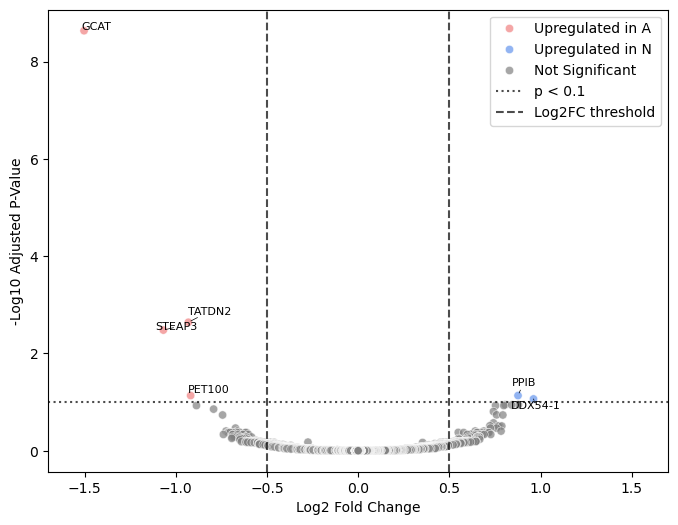

In [6]:


# Thresholds for significance
log2fc_threshold = 0.5
pval_threshold = 0.1

# Avoid -log10(0) issues by replacing 0s with a small value
t_test_results_df["adj_p_value"] = t_test_results_df["adj_p_value"].replace(0, 1e-10)

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in N"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in A"

# Define color mapping
# Define color mapping
palette = {
    "Not Significant": "gray",
    "Upregulated in N": "cornflowerblue",
    "Upregulated in A": "lightcoral"
}


# Create volcano plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=t_test_results_df, 
    x="log2_fc", 
    y="-log10_adj_p", 
    hue="significance",
    palette=palette,
    alpha=0.7
)

# Highlight top 20 most significant proteins
top_genes = t_test_results_df.nsmallest(6, "adj_p_value")
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8))

# Use adjustText to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Formatting
plt.axhline(-np.log10(pval_threshold), linestyle="dotted", color="black", alpha=0.7, label=("p < "+str(pval_threshold)))  # P-value threshold line
plt.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7, label="Log2FC threshold")  # Log2FC threshold lines
plt.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-Value")
plt.xlim([-1.7,1.7])
#plt.title("Volcano Plot of Differential Expression")
plt.legend(loc="upper right")
plt.show()


## T test for ALL passages of A and N, by each passage

In [7]:
adata.obs["group"] = adata.obs["condition"].astype(str) + adata.obs["passage"].astype(str)

In [8]:
t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for passage_num in range(1,2):  # Adjust range as needed
    group1 = f"N{passage_num}"
    group2 = f"A{passage_num}"

    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]
    print(len(A_data))
    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (avoid division by zero by adding a small constant)
    A_mean = np.mean(A_data, axis=0)  # Adding small constant to prevent log issues
    N_mean = np.mean(N_data, axis=0) 
    #log2_fc = np.log2(A_mean / N_mean)
    log2_fc=N_mean - A_mean
    # Perform vectorized t-test
    t_stat, p_values = ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(t_test_results_df["p_value"].fillna(1), method='fdr_bh')[1]

# Sort results by significance
t_test_results_df = t_test_results_df.sort_values(by="p_value")

# Display results
print(t_test_results_df[:20])


4
        protein  passage   p_value   log2_fc  adj_p_value
2460     POLR2A        1  0.000103 -1.434595     0.971154
1739      NUDT3        1  0.000204 -1.565238     0.971154
4545       EML3        1  0.000606  0.420192     0.998779
367    SLC22A23        1  0.001045  2.253515     0.998779
9166     SSX2IP        1  0.001383  1.757657     0.998779
4133       FAT1        1  0.001704 -0.833605     0.998779
1840      HMGCR        1  0.001853  0.531058     0.998779
7600    HYCC1-1        1  0.001954 -1.589764     0.998779
6571     TATDN2        1  0.002212  1.369847     0.998779
3831  SMARCB1-1        1  0.002420  1.413296     0.998779
1838      C4BPA        1  0.002511 -0.879768     0.998779
9108     MGAT4B        1  0.002690 -1.657986     0.998779
1157      SPRY1        1  0.002787 -0.965373     0.998779
8578     MRPL35        1  0.003008  0.714376     0.998779
4861     STRIP1        1  0.003185  1.944864     0.998779
6496     GTF2H4        1  0.003679  1.381233     0.998779
5207      HS

In [9]:
print(t_test_results_df.sort_values(by='adj_p_value'))


       protein  passage   p_value   log2_fc  adj_p_value
2460    POLR2A        1  0.000103 -1.434595     0.971154
1739     NUDT3        1  0.000204 -1.565238     0.971154
2828    PIK3CA        1  0.639757 -0.142185     0.998779
4372     HMGN3        1  0.639816 -0.153135     0.998779
2827  AKR1C3-1        1  0.639933 -0.225274     0.998779
...        ...      ...       ...       ...          ...
7898    CIAO2A        1  0.991363 -0.005968     0.999803
6533      UFD1        1  0.991305 -0.007356     0.999803
7580     KDM5D        1  0.992450 -0.004059     0.999803
9498   FAM169A        1  0.999892 -0.000045     0.999990
7571      GON7        1  0.999990  0.000009     0.999990

[9518 rows x 5 columns]


In [10]:
# Define the filename
#filename = "t_test_AN_passage6_06052025.pkl"

# Save the object
#with open(filename, "wb") as f:
  #  pickle.dump(t_test_results_df, f)

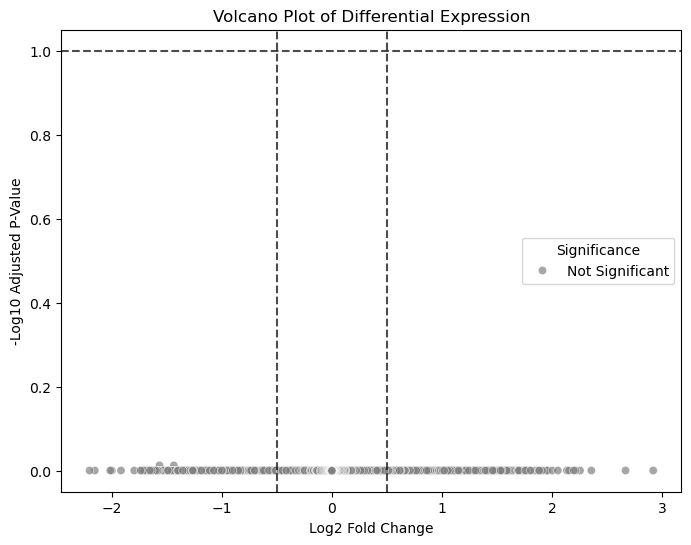

In [11]:

# Thresholds for significance
log2fc_threshold = .5
pval_threshold = 0.1

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & (t_test_results_df["log2_fc"].abs() > log2fc_threshold), 
    "significance"
] = "Significant"

# Plot volcano plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=t_test_results_df, 
    x="log2_fc", 
    y="-log10_adj_p", 
    hue="significance",
    palette={"Not Significant": "gray", "Significant": "red"},
    alpha=0.7
)

# Highlight top genes
top_genes = t_test_results_df[t_test_results_df["significance"] == "Significant"].nlargest(20, "-log10_adj_p")
for i, row in top_genes.iterrows():
    plt.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

# Formatting
plt.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
plt.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
plt.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot of Differential Expression")
plt.legend(title="Significance")
plt.show()


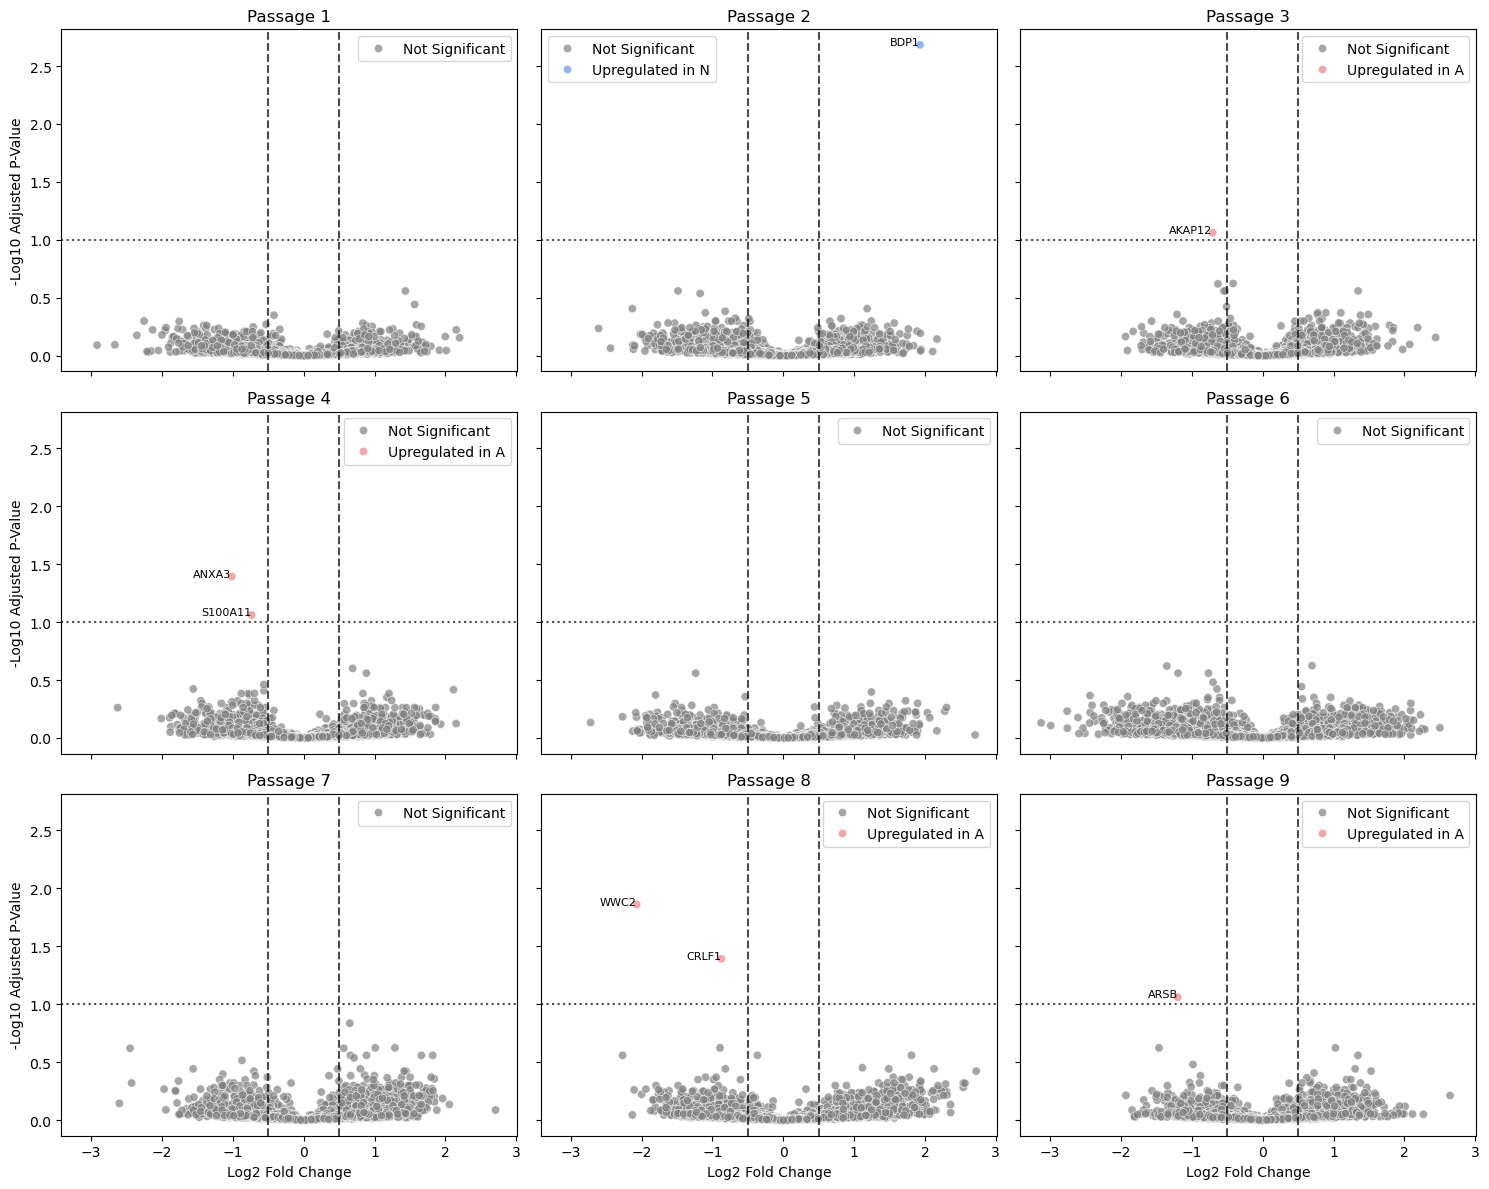

In [12]:


# Define figure and axes for 9 subplots (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(1, 10)):  # Loop through passages 1 to 9
    group1 = f"A{passage_num}"
    group2 = f"N{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Define thresholds
log2fc_threshold = 0.5
pval_threshold = 0.1

# Categorize proteins based on significance and direction
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in N"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in A"

# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(1, 10)):
    ax = axes[i // 3, i % 3]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Define color mapping
    color_palette = {
        "Not Significant": "gray", 
        "Upregulated in A": "lightcoral",
        "Upregulated in N": "cornflowerblue"
    }

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dotted", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=None)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [13]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant  Upregulated in A  Upregulated in N
passage                                                          
1                        9518                 0                 0
2                        9517                 0                 1
3                        9517                 1                 0
4                        9516                 2                 0
5                        9518                 0                 0
6                        9518                 0                 0
7                        9518                 0                 0
8                        9516                 2                 0
9                        9517                 1                 0
significance
Not Significant     85655
Upregulated in A        6
Upregulated in N        1
dtype: int64


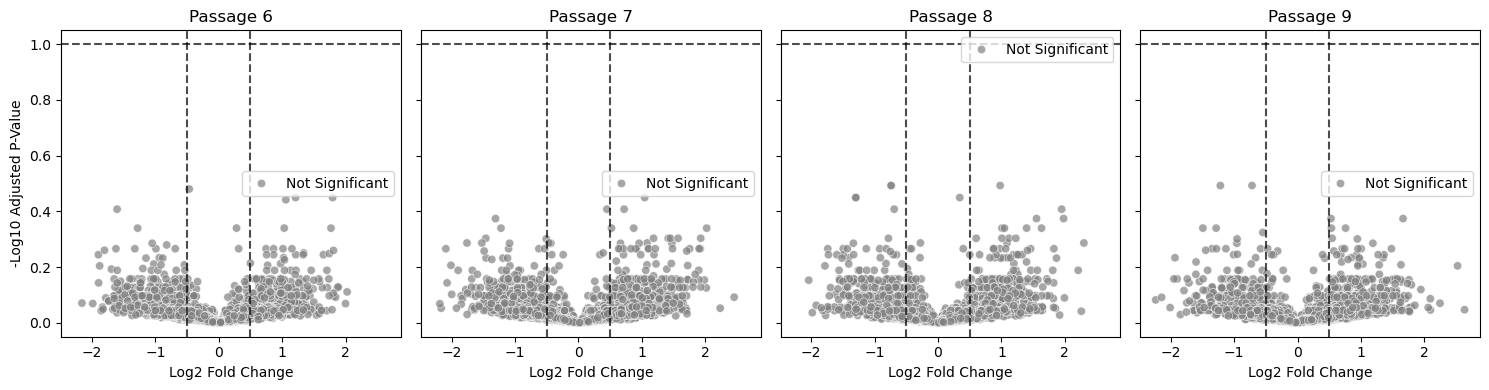

In [14]:

# Define figure and axes for 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(6, 10)):  # Loop through passages 1 to 9
    group1 = f"A{passage_num}"
    group2 = f"AN{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
log2fc_threshold = 0.5
pval_threshold = 0.1
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in AN"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in A"
    # Define color mapping

color_palette = {
        "Not Significant": "gray", 
        "Upregulated in AN": "sandybrown",
        "Upregulated in A": "lightcoral"
    }


# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(6, 10)):
    ax = axes[i]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=False)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [15]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant
passage                      
6                        9518
7                        9518
8                        9518
9                        9518
significance
Not Significant    38072
dtype: int64


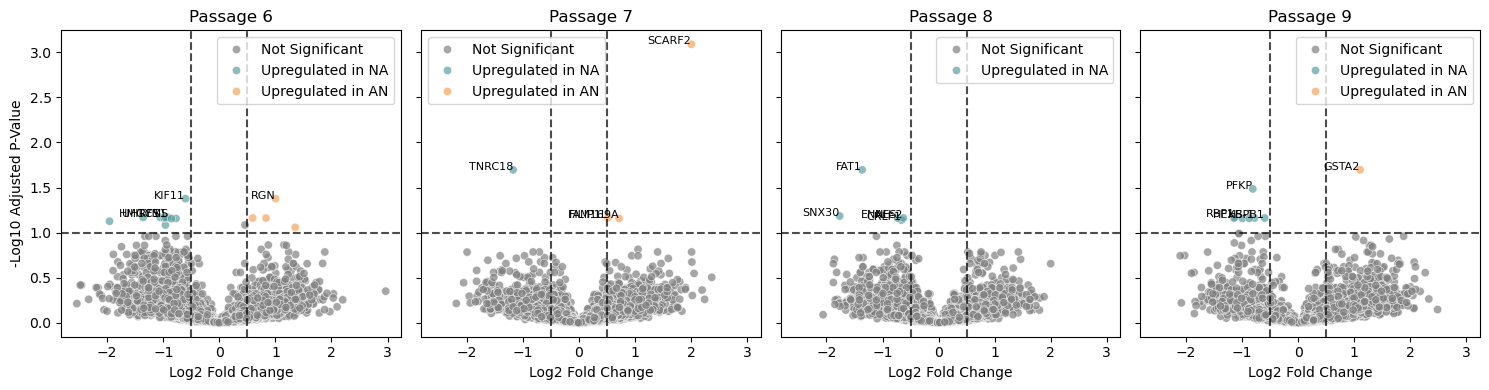

In [16]:


# Define figure and axes for 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(6, 10)):  # Loop through passages 1 to 9
    group1 = f"NA{passage_num}"
    group2 = f"AN{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
log2fc_threshold = 0.5
pval_threshold = 0.1
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in AN"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in NA"
    # Define color mapping

color_palette = {
        "Not Significant": "gray", 
        "Upregulated in AN": "sandybrown",
        "Upregulated in NA": "cadetblue"
    }

# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(6, 10)):
    ax = axes[i]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=False)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [17]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant  Upregulated in AN  Upregulated in NA
passage                                                            
6                        9502                  4                 12
7                        9514                  3                  1
8                        9513                  0                  5
9                        9510                  1                  7
significance
Not Significant      38039
Upregulated in AN        8
Upregulated in NA       25
dtype: int64


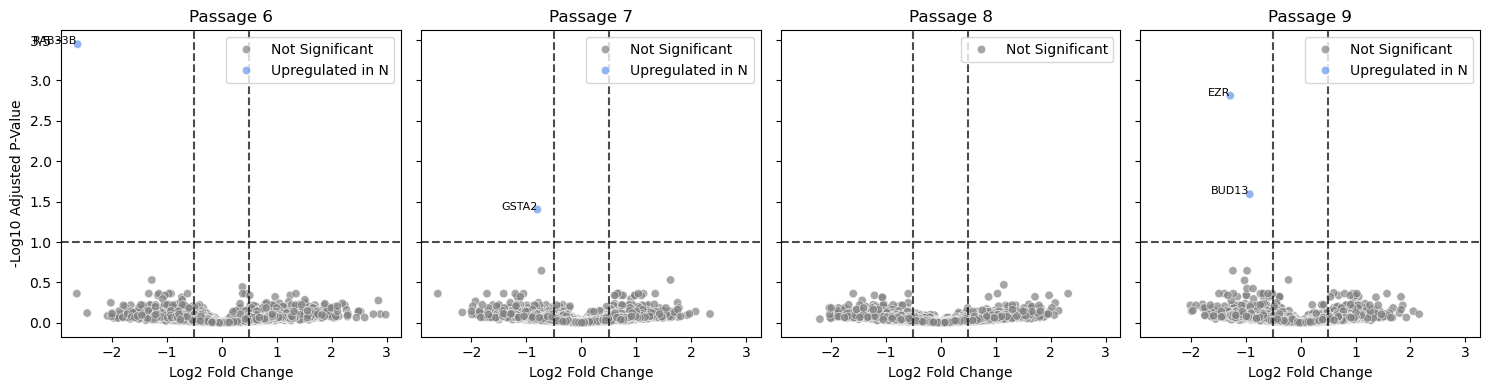

In [18]:


# Define figure and axes for 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(6, 10)):  # Loop through passages 1 to 9
    group1 = f"N{passage_num}"
    group2 = f"AN{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
log2fc_threshold = 0.5
pval_threshold = 0.1
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in AN"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in N"
    # Define color mapping

color_palette = {
        "Not Significant": "gray", 
        "Upregulated in N": "cornflowerblue",
        "Upregulated in AN": "sandybrown"
    }

# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(6, 10)):
    ax = axes[i]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=False)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [19]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant  Upregulated in N
passage                                        
6                        9517                 1
7                        9517                 1
8                        9518                 0
9                        9516                 2
significance
Not Significant     38068
Upregulated in N        4
dtype: int64


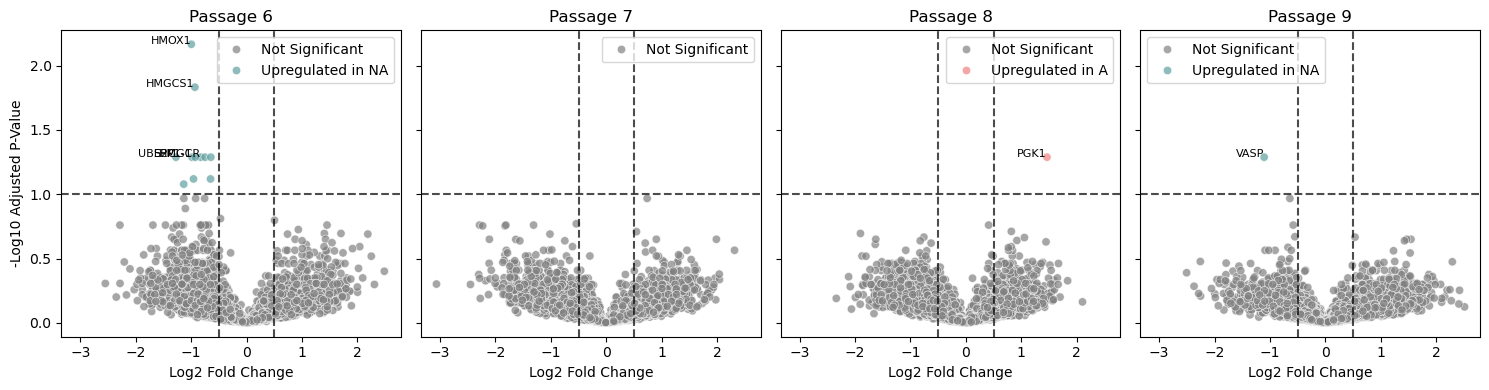

In [20]:

# Define figure and axes for 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(6, 10)):  # Loop through passages 1 to 9
    group1 = f"NA{passage_num}"
    group2 = f"A{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
log2fc_threshold = 0.5
pval_threshold = 0.1
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in A"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in NA"
    # Define color mapping

color_palette = {
        "Not Significant": "gray", 
        "Upregulated in A": "lightcoral",
        "Upregulated in NA": "cadetblue"
    }

# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(6, 10)):
    ax = axes[i]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=False)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [21]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant  Upregulated in A  Upregulated in NA
passage                                                           
6                        9507                 0                 11
7                        9518                 0                  0
8                        9517                 1                  0
9                        9517                 0                  1
significance
Not Significant      38059
Upregulated in A         1
Upregulated in NA       12
dtype: int64


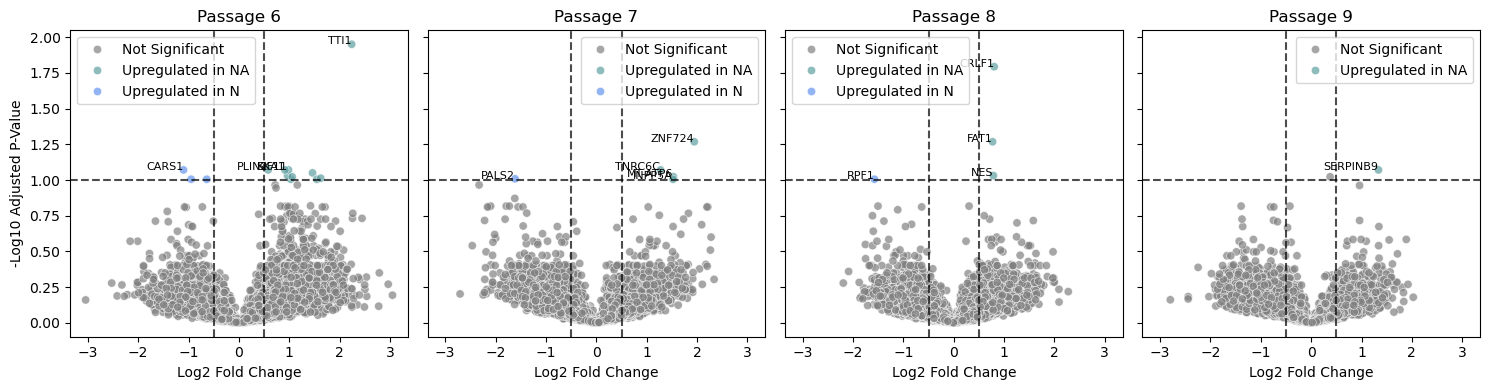

In [22]:


# Define figure and axes for 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

t_test_results = []
results_df = pd.DataFrame([])
t_test_results_df = pd.DataFrame([])

for i, passage_num in enumerate(range(6, 10)):  # Loop through passages 1 to 9
    group1 = f"N{passage_num}"
    group2 = f"NA{passage_num}"
    
    # Select samples from the KNN-imputed layer
    A_data = adata[adata.obs["group"] == group1].layers["knn_imputed_from_log2_total_norm_ds"]
    N_data = adata[adata.obs["group"] == group2].layers["knn_imputed_from_log2_total_norm_ds"]

    # Convert sparse matrices to dense format if needed
    if scipy.sparse.issparse(A_data):
        A_data = A_data.toarray()
    if scipy.sparse.issparse(N_data):
        N_data = N_data.toarray()

    # Remove NaNs
    A_data = np.nan_to_num(A_data, nan=0)
    N_data = np.nan_to_num(N_data, nan=0)

    # Compute log2 fold change (since data is already log2, we subtract)
    A_mean = np.mean(A_data, axis=0)
    N_mean = np.mean(N_data, axis=0)
    log2_fc = N_mean - A_mean

    # Perform vectorized t-test
    t_stat, p_values = stats.ttest_ind(A_data, N_data, axis=0, equal_var=True, nan_policy="omit")

    # Store results
    results_df = pd.DataFrame({
        "protein": adata.var_names,
        "passage": passage_num,
        "p_value": p_values,
        "log2_fc": log2_fc
    })

    t_test_results.append(results_df)

# Combine all passage results after loop
t_test_results_df = pd.concat(t_test_results, ignore_index=True)

# FDR correction for multiple testing
t_test_results_df["adj_p_value"] = smm.multipletests(
    t_test_results_df["p_value"].fillna(1), method='fdr_bh'
)[1]

# Compute -log10 of adjusted p-values
t_test_results_df["-log10_adj_p"] = -np.log10(t_test_results_df["adj_p_value"])

# Categorize proteins based on significance
log2fc_threshold = 0.5
pval_threshold = 0.1
t_test_results_df["significance"] = "Not Significant"
t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] > log2fc_threshold), 
    "significance"
] = "Upregulated in NA"

t_test_results_df.loc[
    (t_test_results_df["adj_p_value"] < pval_threshold) & 
    (t_test_results_df["log2_fc"] < -log2fc_threshold), 
    "significance"
] = "Upregulated in N"
    # Define color mapping

color_palette = {
        "Not Significant": "gray", 
        "Upregulated in N": "cornflowerblue",
        "Upregulated in NA": "cadetblue"
    }
# Loop again to plot volcano plots in subplots
for i, passage_num in enumerate(range(6, 10)):
    ax = axes[i]  # Select subplot location in 3x3 grid
    
    # Select data for the current passage
    passage_data = t_test_results_df[t_test_results_df["passage"] == passage_num]

    # Plot volcano plot
    sns.scatterplot(
        data=passage_data, 
        x="log2_fc", 
        y="-log10_adj_p", 
        hue="significance",
        palette=color_palette,
        alpha=0.7,
        ax=ax
    )

    # Highlight top genes
    top_genes = passage_data[passage_data["significance"] != "Not Significant"].nlargest(5, "-log10_adj_p")
    for _, row in top_genes.iterrows():
        ax.text(row["log2_fc"], row["-log10_adj_p"], row["protein"], fontsize=8, ha='right')

    # Formatting
    ax.axhline(-np.log10(pval_threshold), linestyle="dashed", color="black", alpha=0.7)  # P-value threshold line
    ax.axvline(-log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)  # Log2FC threshold lines
    ax.axvline(log2fc_threshold, linestyle="dashed", color="black", alpha=0.7)
    ax.legend(title=False)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-Log10 Adjusted P-Value")
    ax.set_title(f"Passage {passage_num}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [23]:
# Group by passage and significance, then count
significance_by_passage = t_test_results_df.groupby(['passage', 'significance']).size().unstack(fill_value=0)

# Display the result
print(significance_by_passage)
print(significance_by_passage.sum())

significance  Not Significant  Upregulated in N  Upregulated in NA
passage                                                           
6                        9505                 3                 10
7                        9513                 1                  4
8                        9514                 1                  3
9                        9517                 0                  1
significance
Not Significant      38049
Upregulated in N         5
Upregulated in NA       18
dtype: int64


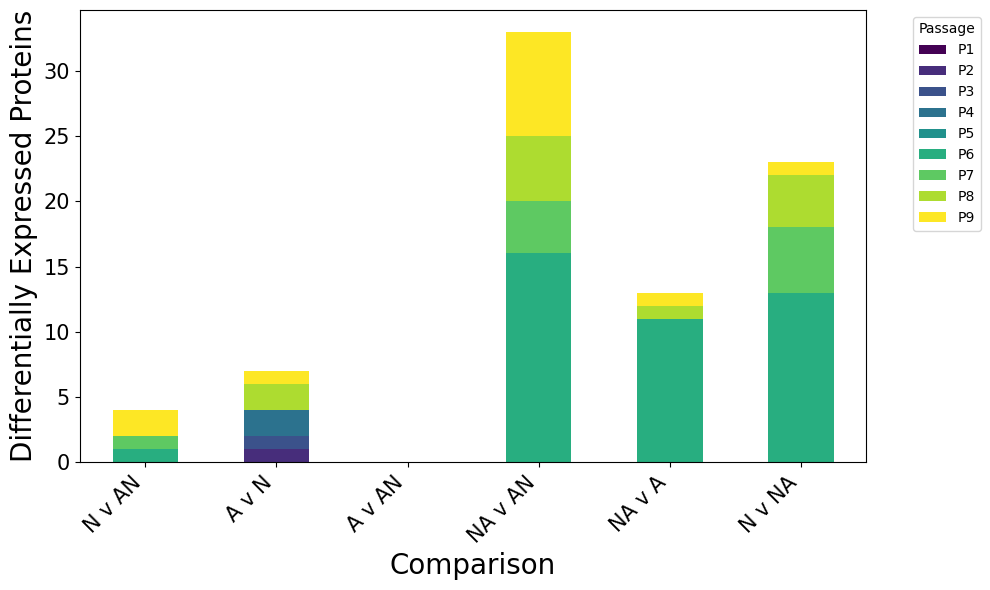

In [24]:


# Recreate the table as a DataFrame
data = {
    'Comparison': ['N v AN', 'A v N', 'A v AN', 'NA v AN', 'NA v A', 'N v NA'],
    'P1': [0, 0, 0, 0, 0, 0],
    'P2': [0, 1, 0, 0, 0, 0],
    'P3': [0, 1, 0, 0, 0, 0],
    'P4': [0, 2, 0, 0, 0, 0],
    'P5': [0, 0, 0, 0, 0, 0],
    'P6': [1, 0, 0, 16, 11, 13],
    'P7': [1, 0, 0, 4, 0, 5],
    'P8': [0, 2, 0, 5, 1, 4],
    'P9': [2, 1, 0, 8, 1, 1]
}

df = pd.DataFrame(data)
df.set_index('Comparison', inplace=True)

# Plot: comparisons on x-axis, passages as stacked bars
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.ylabel('Differentially Expressed Proteins',fontsize=20)
#plt.title('Differential Expression by Comparison and Passage')
plt.xlabel('Comparison',fontsize=20)
plt.legend(title='Passage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right',fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()
